In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()
matplotlib.rcParams.update({'font.size': 10})


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/small-large/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-09-06 16:24:41,320 - hbmep.config - INFO - Verifying configuration ...
2023-09-06 16:24:41,320 - hbmep.config - INFO - Success!
2023-09-06 16:24:41,333 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-09-06 16:24:41,377 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/fcr
2023-09-06 16:24:41,377 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/fcr
2023-09-06 16:24:41,378 - hbmep.dataset.core - INFO - Processing data ...
2023-09-06 16:24:41,382 - hbmep.utils.utils - INFO - func:load took: 0.01 sec


In [10]:
21 + 64 + 8 + 21 + 81

195

In [7]:
174 - 114

60

In [3]:
combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x size
combinations_inv = [
    (
        encoder_dict[model.subject].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[0]].inverse_transform(np.array([c[1]]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([c[2]]))[0]
    ) for c in combinations
]

conditions = model._make_combinations(df=df, columns=model.combination_columns[1:]) # pos x size
conditions_inv = [
    (
        encoder_dict[model.features[0]].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([c[1]]))[0]
    ) for c in conditions
]
conditions_inv_joined = ["::".join(c) for c in conditions_inv]

####
combinations_inv_ = [
    (
        c[0], c[1].split("-")[0][:2] + "-" + c[1].split("-")[1][:2], c[1].split("-")[0][2:] + "-" + c[1].split("-")[1][2:] + "::" + c[2]
    )
    for c in combinations_inv
]

lateral_combinations = np.unique(np.array(
    [c[-1] for c in combinations_inv_]
)).tolist()


In [26]:
len(combinations)

403

In [32]:
model.features

['compound_position', 'compound_size']

In [35]:
encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]

LabelEncoder()

In [29]:
pos_size = df[model.features].apply(tuple, axis=1).unique().tolist()

pos_size_inv = [
    (
        encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([size]))[0]
    ) for pos, size in pos_size
]

In [30]:
t = [
    (pos, size) for pos, size in pos_size_inv if "R" not in pos
]

len(t)

57

In [33]:
21 + 64 + 21 + 8 + 81

195

In [35]:
64-21

43

In [50]:
big_size = [
    (pos, size) for pos, size in pos_size_inv if size == "B" and pos.split("-")[0] != "" and pos.split("-")[0][2:] == "M" and pos.split("-")[1][2:] in {"L", "LL", "M", "LM"}
]

len(big_size)

6

In [51]:
small_size = [
    (pos, size) for pos, size in pos_size_inv if size == "S" and pos.split("-")[0] != "" and pos.split("-")[0][2:] == "M" and pos.split("-")[1][2:] in {"L", "LL", "LM1", "LM2", "M"}
]

len(small_size)

8

In [52]:
big_size_g = [
    (pos, size) for pos, size in pos_size_inv if size == "B" and pos.split("-")[0] == "" and pos.split("-")[1][2:] in {"L", "LL", "M", "LM"}
]

len(big_size_g)

10

In [53]:
small_size_g = [
    (pos, size) for pos, size in pos_size_inv if size == "B" and pos.split("-")[0] == "" and pos.split("-")[1][2:] in {"L", "LL", "LM1", "LM2", "M"}
]

len(small_size_g)

7

In [49]:
big_size_g

[('-C5LL', 'B'),
 ('-C5M', 'B'),
 ('-C5LM', 'B'),
 ('-C5L', 'B'),
 ('-C6LM', 'B'),
 ('-C6LL', 'B'),
 ('-C6L', 'B'),
 ('-C6M', 'B'),
 ('-C6R', 'B'),
 ('-C6RR', 'B'),
 ('-C6RM', 'B'),
 ('-C7LM', 'B'),
 ('-C7M', 'B'),
 ('-C7R', 'B'),
 ('-C7RR', 'B'),
 ('-C7RM', 'B')]

In [37]:
pos_size_inv

[('-C5LL', 'B'),
 ('C5M-C5LM', 'B'),
 ('-C5M', 'B'),
 ('C5M-C5LL', 'B'),
 ('-C5LM', 'B'),
 ('-C5L', 'B'),
 ('C5M-C5L', 'B'),
 ('C5M-C6LL', 'S-B'),
 ('-C5LM2', 'S'),
 ('C6RM-C6RR', 'B'),
 ('C6M-C6RM', 'B'),
 ('-C6LM', 'B'),
 ('C5LM1-C5L', 'S'),
 ('-C5M', 'S'),
 ('C6RM-C6R', 'B'),
 ('-C5L', 'S'),
 ('-C5LL', 'S'),
 ('C5LM2-C5L', 'S'),
 ('-C6LL', 'B'),
 ('-C6L', 'B'),
 ('C6LM-C6RM', 'B'),
 ('C5LM2-C6L', 'S-B'),
 ('-C6M', 'B'),
 ('C5LM1-C5LL', 'S'),
 ('-C6R', 'B'),
 ('-C5LM1', 'S'),
 ('C5LM2-C6LL', 'S-B'),
 ('-C6RR', 'B'),
 ('C6LM-C6M', 'B'),
 ('C5LM2-C5LL', 'S'),
 ('C5M-C6L', 'S-B'),
 ('C5LM2-C5LM1', 'S'),
 ('C6LM-C6RR', 'B'),
 ('C5LM2-C5M', 'S'),
 ('C6M-C6RR', 'B'),
 ('C6R-C6RR', 'B'),
 ('C6M-C6R', 'B'),
 ('C5L-C5LL', 'S'),
 ('-C6RM', 'B'),
 ('C6LM-C6R', 'B'),
 ('C6LL-C6L', 'B'),
 ('C7RM-C7RR', 'B'),
 ('C7M-C7RM', 'B'),
 ('-C7LM', 'B'),
 ('C7RM-C7R', 'B'),
 ('C7LM-C7RM', 'B'),
 ('-C7M', 'B'),
 ('-C7R', 'B'),
 ('-C7RR', 'B'),
 ('C7LM-C7M', 'B'),
 ('C7LM-C7RR', 'B'),
 ('C7M-C7RR', 'B'),
 ('

In [31]:
df[model.features].apply(tuple, axis=1).nunique()

81

## Efficay

### Process

In [4]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
a = None

for muscle in muscles:
    a_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}/{c_inv[2]}"

        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0, 0]
        a_temp = a_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)

    a_muscle = a_muscle[..., None]

    if a is None:
        a = a_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)


In [5]:
a.shape

(4, 6000, 403, 6)

In [6]:
t = az.summary({"a": a})
t.shape

(2418, 9)

In [7]:
(t.r_hat > 1.05).sum()

42

In [8]:
t.r_hat.max()

1.53

In [9]:
a = a.reshape(-1, *a.shape[2:])
a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0, independent=True))
a_map = a.mean(axis=0)

a.shape

(24000, 403, 6)

In [10]:
a_map.shape

(403, 6)

In [11]:
def _process(keep_lateral_combinations: list, keep_muscles: list[str], threshold: int):
    keep_muscles_ind = [i for i, muscle in enumerate(muscles) if muscle in keep_muscles]

    pr = []
    effect_size = []
    t_test = []
    rank_test = []
    heat_map = []
    mask = []

    for i, i_lc in enumerate(keep_lateral_combinations):
        curr_pr = []
        curr_effect_size = []
        curr_t_test = []
        curr_rank_test = []
        curr_heat_map = []
        curr_mask = []

        for j, j_lc in enumerate(keep_lateral_combinations):
            if i == j:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"D")
                curr_mask.append(False)
                continue

            i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
            j_com = [(j, c) for j, c in enumerate(combinations_inv_) if c[-1] == j_lc]

            i_com = sorted(i_com, key=lambda x: (x[1][0], x[1][1]))
            j_com = sorted(j_com, key=lambda x: (x[1][0], x[1][1]))

            i_sub_pos = set([(v[1][0], v[1][1]) for v in i_com])
            j_sub_pos = set([(v[1][0], v[1][1]) for v in j_com])
            common_sub_pos = i_sub_pos.intersection(j_sub_pos)

            i_ind = [v[0] for v in i_com if (v[1][0], v[1][1]) in common_sub_pos]
            j_ind = [v[0] for v in j_com if (v[1][0], v[1][1]) in common_sub_pos]

            N = len(common_sub_pos) * len(keep_muscles_ind)

            if not len(common_sub_pos) or len(common_sub_pos) < threshold:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"NA:0")
                curr_mask.append(False)
                continue

            curr_mask.append(True)

            ## Distributions
            i_a = a[:, i_ind, ...]
            i_a = i_a[..., keep_muscles_ind]
            i_a = i_a.reshape(i_a.shape[0], -1)

            j_a = a[:, j_ind, ...]
            j_a = j_a[..., keep_muscles_ind]
            j_a = j_a.reshape(j_a.shape[0], -1)

            diff_a = i_a - j_a
            diff_a_mu = diff_a.mean(axis=-1)
            pr_a_mu = (diff_a_mu < 0).mean()
            curr_pr.append(pr_a_mu)

            ## Effect-size
            i_mu_a_estimate = i_a.mean(axis=-1)
            i_sigma_sq_a_estimate = np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            j_mu_a_estimate = j_a.mean(axis=-1)
            j_sigma_sq_a_estimate = np.power(j_a - j_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            i_j_effect_size = (i_mu_a_estimate - j_mu_a_estimate) / np.power( (i_sigma_sq_a_estimate + j_sigma_sq_a_estimate) / 2, 0.5)
            hpdi_interval_lo, hpdi_interval_hi = hpdi(i_j_effect_size, prob=.95)
            curr_effect_size.append((hpdi_interval_lo, hpdi_interval_hi))

            curr_heat_map.append(f"{pr_a_mu:.2f}:{len(common_sub_pos)}\n({hpdi_interval_lo:.2f}, {hpdi_interval_hi:.2f})")

            ## MAP
            i_map = a_map[i_ind, ...]
            i_map = i_map[..., keep_muscles_ind]
            i_map = i_map.reshape(-1,)

            j_map = a_map[j_ind, ...]
            j_map = j_map[..., keep_muscles_ind]
            j_map = j_map.reshape(-1,)

            diff_map = i_map - j_map
            t_test_map = stats.ttest_1samp(a=diff_map, popmean=0, alternative="less")
            rank_test_map = stats.wilcoxon(x=diff_map, alternative="less")

            curr_t_test.append(t_test_map.pvalue)
            curr_rank_test.append(rank_test_map.pvalue)

        pr.append(curr_pr)
        effect_size.append(curr_effect_size)
        t_test.append(curr_t_test)
        rank_test.append(curr_rank_test)
        heat_map.append(curr_heat_map)
        mask.append(curr_mask)

    pr = np.array(pr)
    effect_size = np.array(effect_size)
    t_test = np.array(t_test)
    rank_test = np.array(rank_test)
    heat_map = np.array(heat_map)
    mask = np.array(mask)

    return pr, effect_size, t_test, rank_test, heat_map, mask

In [12]:
efficacy_score = {"g": {}, "ng": {}}

### Non-ground

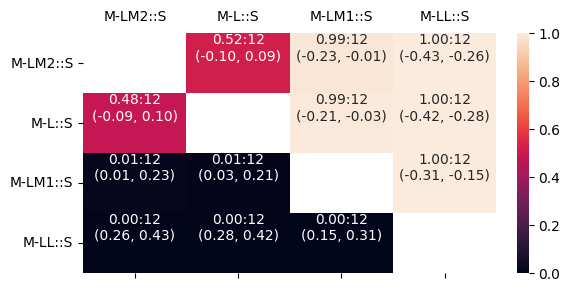

In [13]:
node_size = "S"
first_pattern = {"M"}
second_pattern = {"L", "LL", "LM1", "LM2"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, keep_muscles=keep_muscles, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [14]:
key1 = "ng"
key2 = "lateral_small"
efficacy_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    efficacy_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    efficacy_score[key1][key2][i_lc].append(i_a.mean())


efficacy_score[key1][key2]

{'M-LM2::S': [4, 204.19037141918395],
 'M-L::S': [3, 204.60266226411628],
 'M-LM1::S': [2, 224.0412711855059],
 'M-LL::S': [1, 264.39767942133835]}

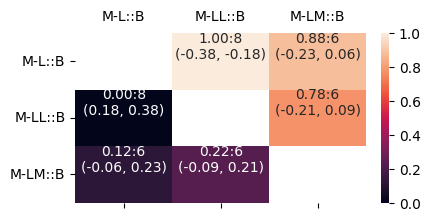

In [15]:
node_size = "B"
first_pattern = {"M"}
second_pattern = {"L", "LL", "LM"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, keep_muscles=keep_muscles, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [16]:
key1 = "ng"
key2 = "lateral_big"
efficacy_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    efficacy_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    efficacy_score[key1][key2][i_lc].append(i_a.mean())


efficacy_score[key1][key2]

{'M-L::B': [3, 80.13162805541506],
 'M-LL::B': [2, 130.72062611318304],
 'M-LM::B': [1, 98.80774370807471]}

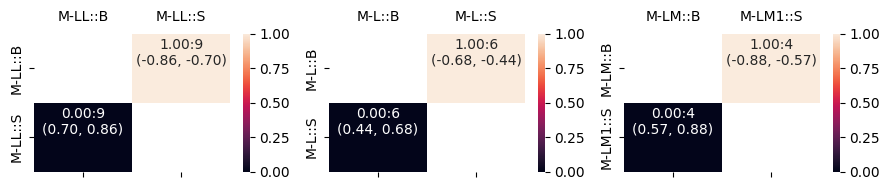

In [17]:
key1 = "ng"
key2 = "small_big"
efficacy_score[key1][key2] = {}

first_pattern = {"M"}
small_aligns = ["LL", "L", "LM1"]
big_aligns = ["LL", "L", "LM"]

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows), tight_layout=True, squeeze=False)

for i in range(3):
    ax = axes[i // ncols, i % ncols]

    small_align = small_aligns[i]
    big_align = big_aligns[i]

    efficacy_score[key1][key2][small_align + "_" + big_align] = {}

    keep_lateral_combinations = [lc for lc in lateral_combinations if (lc.split("::")[1], lc.split("::")[0].split("-")[1]) in {("S", small_align), ("B", big_align)} and lc.split("::")[0].split("-")[0] in first_pattern]

    keep_muscles = muscles

    n_keep_lateral_combinations = len(keep_lateral_combinations)

    pr, effect_size, t_test, rank_test, heat_map, mask = _process(
        keep_lateral_combinations=keep_lateral_combinations, keep_muscles=keep_muscles, threshold=1
    )

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_lateral_combinations)[ind],
        yticklabels=np.array(keep_lateral_combinations)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    ax.tick_params(labeltop=True, labelbottom=False);

    for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
        efficacy_score[key1][key2][small_align + "_" + big_align][lc] = [n_keep_lateral_combinations - i]

    for i, i_lc in enumerate(keep_lateral_combinations):
        i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
        i_ind = [v[0] for v in i_com]

        i_a = a[:, i_ind, ...]
        i_a = i_a.reshape(i_a.shape[0], -1)
        efficacy_score[key1][key2][small_align + "_" + big_align][i_lc].append(i_a.mean())

In [18]:
efficacy_score[key1][key2]["LL_LL"]

{'M-LL::B': [2, 130.72062611318304], 'M-LL::S': [1, 264.39767942133835]}

In [19]:
efficacy_score[key1][key2]["L_L"]


{'M-L::B': [2, 80.13162805541506], 'M-L::S': [1, 204.60266226411628]}

In [20]:
efficacy_score[key1][key2]["LM1_LM"]


{'M-LM::B': [2, 98.80774370807471], 'M-LM1::S': [1, 224.0412711855059]}

### Ground

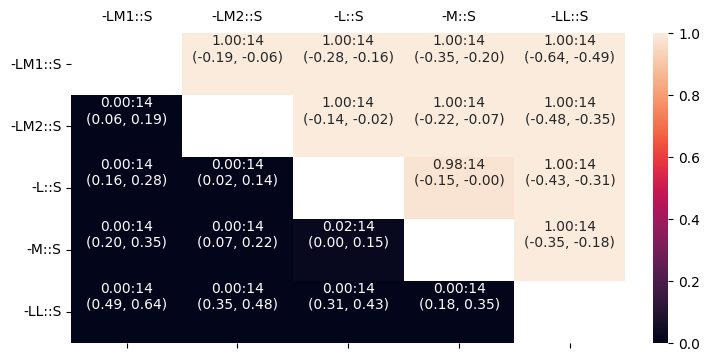

In [21]:
node_size = "S"
first_pattern = {""}
second_pattern = {"L", "LL", "LM1", "LM2", "M"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, keep_muscles=keep_muscles, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [22]:
key1 = "g"
key2 = "lateral_small"
efficacy_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    efficacy_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    efficacy_score[key1][key2][i_lc].append(i_a.mean())


efficacy_score[key1][key2]

{'-LM1::S': [5, 180.5655615878198],
 '-LM2::S': [4, 198.18684532174748],
 '-L::S': [3, 208.4548480741403],
 '-M::S': [2, 218.01293123169265],
 '-LL::S': [1, 251.40703177155828]}

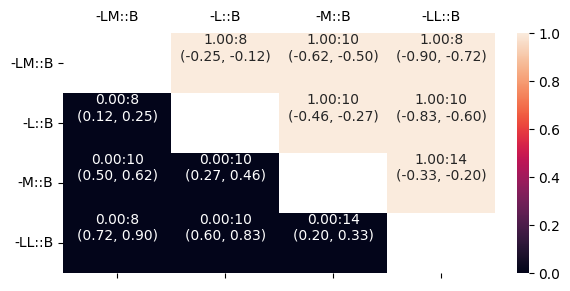

In [23]:
node_size = "B"
first_pattern = {""}
second_pattern = {"L", "LL", "LM", "M"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, keep_muscles=keep_muscles, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [24]:
key1 = "g"
key2 = "lateral_big"
efficacy_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    efficacy_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    efficacy_score[key1][key2][i_lc].append(i_a.mean())


efficacy_score[key1][key2]

{'-LM::B': [4, 84.82723286089902],
 '-L::B': [3, 99.52393031571903],
 '-M::B': [2, 179.00034627844207],
 '-LL::B': [1, 196.30339521364613]}

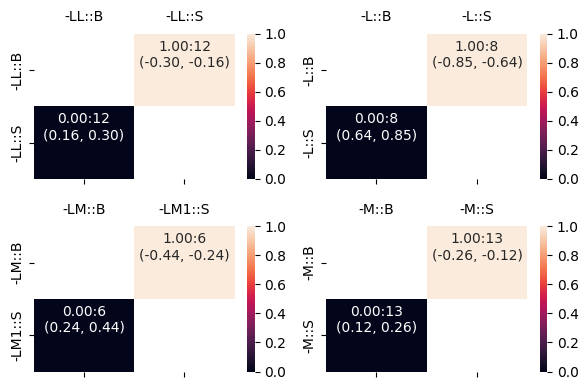

In [25]:
key1 = "g"
key2 = "small_big"
efficacy_score[key1][key2] = {}

first_pattern = {""}
small_aligns = ["LL", "L", "LM1", "M"]
big_aligns = ["LL", "L", "LM", "M"]

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows), tight_layout=True, squeeze=False)

for i in range(4):
    ax = axes[i // ncols, i % ncols]

    small_align = small_aligns[i]
    big_align = big_aligns[i]

    efficacy_score[key1][key2][small_align + "_" + big_align] = {}

    keep_lateral_combinations = [lc for lc in lateral_combinations if (lc.split("::")[1], lc.split("::")[0].split("-")[1]) in {("S", small_align), ("B", big_align)} and lc.split("::")[0].split("-")[0] in first_pattern]

    keep_muscles = muscles

    n_keep_lateral_combinations = len(keep_lateral_combinations)

    pr, effect_size, t_test, rank_test, heat_map, mask = _process(
        keep_lateral_combinations=keep_lateral_combinations, keep_muscles=keep_muscles, threshold=1
    )

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_lateral_combinations)[ind],
        yticklabels=np.array(keep_lateral_combinations)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    ax.tick_params(labeltop=True, labelbottom=False);

    for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
        efficacy_score[key1][key2][small_align + "_" + big_align][lc] = [n_keep_lateral_combinations - i]

    for i, i_lc in enumerate(keep_lateral_combinations):
        i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
        i_ind = [v[0] for v in i_com]

        i_a = a[:, i_ind, ...]
        i_a = i_a.reshape(i_a.shape[0], -1)
        efficacy_score[key1][key2][small_align + "_" + big_align][i_lc].append(i_a.mean())

In [26]:
efficacy_score[key1][key2]["LL_LL"]

{'-LL::B': [2, 196.30339521364613], '-LL::S': [1, 251.40703177155828]}

In [27]:
efficacy_score[key1][key2]["L_L"]


{'-L::B': [2, 99.52393031571903], '-L::S': [1, 208.4548480741403]}

In [28]:
efficacy_score[key1][key2]["LM1_LM"]


{'-LM::B': [2, 84.82723286089902], '-LM1::S': [1, 180.5655615878198]}

In [29]:
efficacy_score[key1][key2]["M_M"]

{'-M::B': [2, 179.00034627844207], '-M::S': [1, 218.01293123169265]}

## Selectivity

### Process

In [30]:
muscles_map = {
    "adm": "auc_1",
    "biceps": "auc_2",
    "deltoid": "auc_4",
    "ecr": "auc_5",
    "fcr": "auc_6",
    "triceps": "auc_7"
}

n_muscles = len(muscles)


In [31]:
a = None
b = None
L = None
H = None
v = None

for muscle in muscles:
    a_muscle = None
    b_muscle = None
    L_muscle = None
    H_muscle = None
    v_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}/{c_inv[2]}"
        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]

        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0, 0]
        a_temp = a_temp[..., None]

        b_temp = mcmc[site.b].to_numpy()
        b_temp = b_temp[..., 0, 0, 0, 0]
        b_temp = b_temp[..., None]

        L_temp = mcmc[site.L].to_numpy()
        L_temp = L_temp[..., 0, 0, 0, 0]
        L_temp = L_temp[..., None]

        H_temp = mcmc[site.H].to_numpy()
        H_temp = H_temp[..., 0, 0, 0, 0]
        H_temp = H_temp[..., None]

        v_temp = mcmc[site.v].to_numpy()
        v_temp = v_temp[..., 0, 0, 0, 0]
        v_temp = v_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
            b_muscle = b_temp
            L_muscle = L_temp
            H_muscle = H_temp
            v_muscle = v_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)
            b_muscle = np.concatenate((b_muscle, b_temp), axis=-1)
            L_muscle = np.concatenate((L_muscle, L_temp), axis=-1)
            H_muscle = np.concatenate((H_muscle, H_temp), axis=-1)
            v_muscle = np.concatenate((v_muscle, v_temp), axis=-1)

    a_muscle = a_muscle[..., None]
    b_muscle = b_muscle[..., None]
    L_muscle = L_muscle[..., None]
    H_muscle = H_muscle[..., None]
    v_muscle = v_muscle[..., None]

    if a is None:
        a = a_muscle
        b = b_muscle
        L = L_muscle
        H = H_muscle
        v = v_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)
        b = np.concatenate((b, b_muscle), axis=-1)
        L = np.concatenate((L, L_muscle), axis=-1)
        H = np.concatenate((H, H_muscle), axis=-1)
        v = np.concatenate((v, v_muscle), axis=-1)

In [32]:
a = a.reshape(-1, *a.shape[2:])
b = b.reshape(-1, *b.shape[2:])
L = L.reshape(-1, *L.shape[2:])
H = H.reshape(-1, *H.shape[2:])
v = v.reshape(-1, *v.shape[2:])

In [33]:
ind = jax.random.permutation(model.rng_key, np.array(range(a.shape[0])))

N_DOWN = 9000
a_down = a[ind, ...][:N_DOWN, ...]
b_down = b[ind, ...][:N_DOWN, ...]
L_down = L[ind, ...][:N_DOWN, ...]
H_down = H[ind, ...][:N_DOWN, ...]
v_down = v[ind, ...][:N_DOWN, ...]

a = a_down
b = b_down
L = L_down
H = H_down
v = v_down


In [34]:
x = None

for muscle in muscles:
    x_muscle = None

    for i, c in enumerate(combinations):
        ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        lo, hi = temp_df[model.intensity].min(), temp_df[model.intensity].max()
        x_temp = np.linspace(lo, hi, 100)
        x_temp = x_temp[..., None]

        if x_muscle is None:
            x_muscle = x_temp
        else:
            x_muscle = np.concatenate((x_muscle, x_temp), axis=-1)

    x_muscle = x_muscle[..., None]

    if x is None:
        x = x_muscle
    else:
        x = np.concatenate((x, x_muscle), axis=-1)

x = x[:, None, ...]

In [35]:
x.shape

(100, 1, 403, 6)

In [36]:
assert np.unique(x.min(axis=(0, 1)), axis=1).shape[1] == 1

In [37]:
assert np.unique(x.max(axis=(0, 1)), axis=1).shape[1] == 1

In [38]:
a.shape

(9000, 403, 6)

In [39]:
x.shape

(100, 1, 403, 6)

In [40]:
y = L + jnp.maximum(
    0,
    -1
    + (H + 1)
    / jnp.power(
        1
        + (jnp.power(1 + H, v) - 1)
        * jnp.exp(-b * (x - a)),
        1 / v
    )
)

y.shape

(100, 9000, 403, 6)

In [41]:
y_map = y.mean(axis=1)
y_map.shape

(100, 403, 6)

In [42]:
y_max = None

for i, (sub, pos, size) in enumerate(combinations):
    com = [(j, c) for j, c in enumerate(combinations) if c[0] == sub]
    ind = [v[0] for v in com]
    y_max_temp = y_map[:, ind, ...].max(axis=(0, 1))
    y_max_temp = y_max_temp[None, ...]

    if y_max is None:
        y_max = y_max_temp
    else:
        y_max = np.concatenate((y_max, y_max_temp), axis=0)

y_max = y_max[None, None , ...]

y_max.shape


(1, 1, 403, 6)

In [43]:
y.shape

(100, 9000, 403, 6)

In [44]:
y = y / y_max

y.shape

(100, 9000, 403, 6)

In [45]:
y_ratio = y / y.sum(axis=-1)[..., None]

y_ratio.shape

(100, 9000, 403, 6)

In [46]:
import gc

del y, b, L, H, v
gc.collect()

0

In [47]:
entropy_adj = 1 + (
    (y_ratio * jnp.log(y_ratio)).sum(axis=-1)
    / jnp.log(n_muscles)
)

entropy_adj.shape

(100, 9000, 403)

In [48]:
entropy_adj = np.array(jax.random.permutation(model.rng_key, x=entropy_adj, axis=1, independent=True))
entropy_adj.shape

(100, 9000, 403)

In [49]:
entropy_adj_map = entropy_adj.mean(axis=1)
entropy_adj_map.shape

(100, 403)

In [50]:
entropy_adj_hpdi = hpdi(entropy_adj, axis=1)
entropy_adj_hpdi.shape

(100, 2, 403)

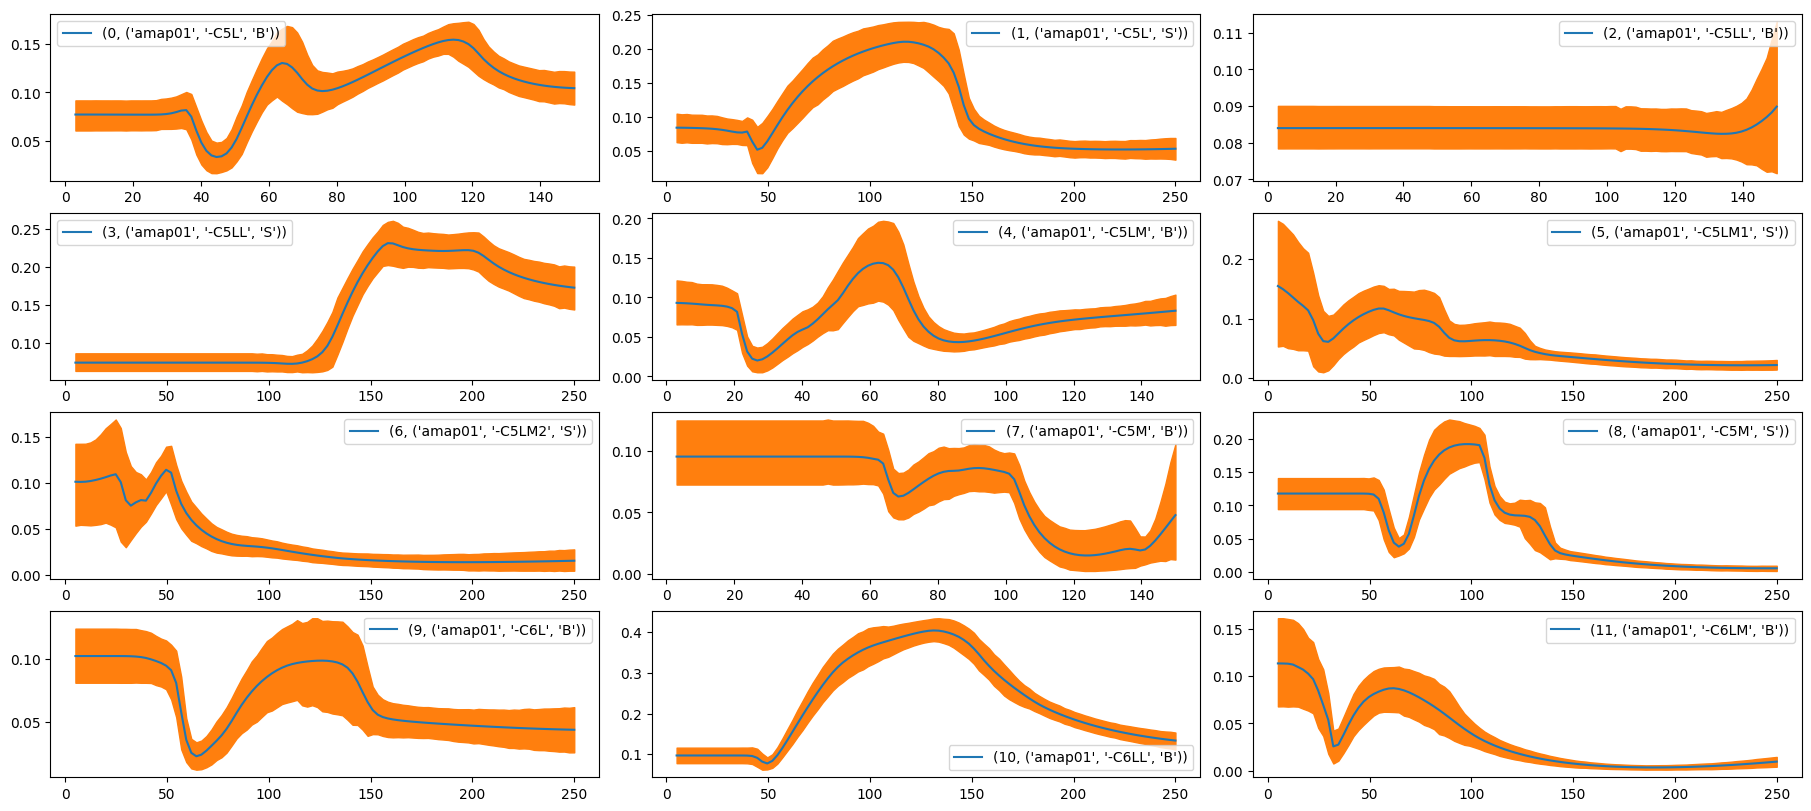

In [51]:
nrows = 4
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 2 * nrows), constrained_layout=True)

for i in range(12):
    ax = axes[i // ncols, i % ncols]
    sns.lineplot(x=x[:, 0, i, 0], y=entropy_adj_map[:, i], label=f"{i, combinations_inv[i]}", ax=ax)
    ax.fill_between(
    x[:, 0, i, 0],
    entropy_adj_hpdi[:, 0, i],
    entropy_adj_hpdi[:, 1, i],
    color="C1",
    label="95% HPDI"
    )

In [52]:
x.shape

(100, 1, 403, 6)

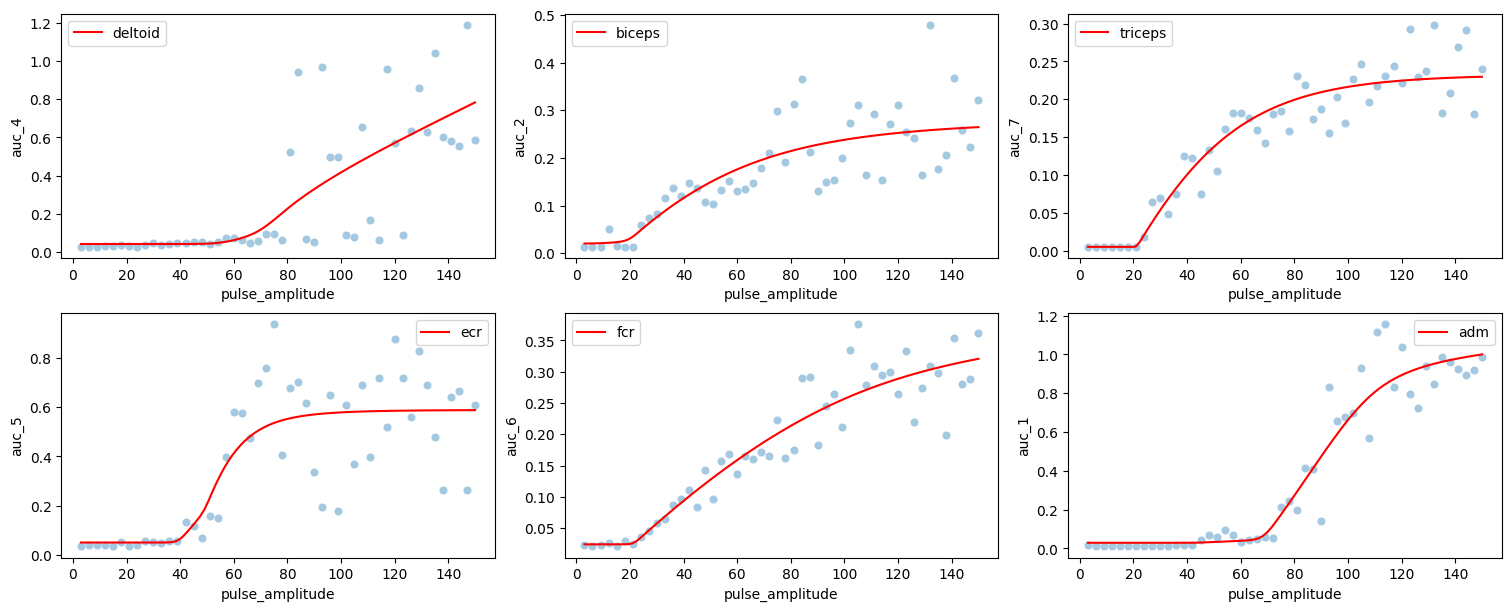

In [53]:
c_ind = 4
c = combinations[c_ind]

ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_muscles)))

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True)

for i in range(n_muscles):
    muscle_ind = i
    muscle = muscles[muscle_ind]
    ax = axes[i // ncols, i % ncols]
    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[muscles_map[muscle]] / y_max[0, 0, c_ind, muscle_ind], ax=ax, alpha=.4)
    sns.lineplot(x=x[:, 0, c_ind, 0], y=y_map[:, c_ind, muscle_ind] / y_max[0, 0, c_ind, muscle_ind], ax=ax, color="r", label=f"{muscle}")

In [54]:
entropy_adj.shape

(100, 9000, 403)

In [55]:
def _process(keep_lateral_combinations: list, threshold: int):
    keep_muscles_ind = [i for i, muscle in enumerate(muscles) if muscle in keep_muscles]

    pr = []
    heat_map = []
    mask = []

    for i, i_lc in enumerate(keep_lateral_combinations):
        curr_pr = []
        curr_heat_map = []
        curr_mask = []

        for j, j_lc in enumerate(keep_lateral_combinations):
            if i == j:
                curr_pr.append(0)
                curr_heat_map.append(f"D")
                curr_mask.append(False)
                continue

            i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
            j_com = [(j, c) for j, c in enumerate(combinations_inv_) if c[-1] == j_lc]

            i_com = sorted(i_com, key=lambda x: (x[1][0], x[1][1]))
            j_com = sorted(j_com, key=lambda x: (x[1][0], x[1][1]))

            i_sub_pos = set([(v[1][0], v[1][1]) for v in i_com])
            j_sub_pos = set([(v[1][0], v[1][1]) for v in j_com])
            common_sub_pos = i_sub_pos.intersection(j_sub_pos)

            i_ind = [v[0] for v in i_com if (v[1][0], v[1][1]) in common_sub_pos]
            j_ind = [v[0] for v in j_com if (v[1][0], v[1][1]) in common_sub_pos]

            N = len(common_sub_pos) * len(keep_muscles_ind)

            if not len(common_sub_pos) or len(common_sub_pos) < threshold:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"NA:0")
                curr_mask.append(False)
                continue

            curr_mask.append(True)

            ## Distributions
            i_entropy = entropy_adj[..., i_ind]
            i_entropy = i_entropy.mean(axis=-1)
            i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
            i_entropy = i_entropy[i_amp_ind, :]

            j_entropy = entropy_adj[..., j_ind]
            j_entropy = j_entropy.mean(axis=-1)
            j_amp_ind = np.argmax(j_entropy.mean(axis=-1))
            j_entropy = j_entropy[j_amp_ind, :]

            # diff should be > 0 for i to be more selective than j
            diff_entropy = i_entropy - j_entropy
            pr_entropy = (diff_entropy > 0).mean()
            curr_pr.append(pr_entropy)
            curr_heat_map.append(f"{pr_entropy:.2f}:{len(common_sub_pos)}")

        pr.append(curr_pr)
        heat_map.append(curr_heat_map)
        mask.append(curr_mask)

    pr = np.array(pr)
    heat_map = np.array(heat_map)
    mask = np.array(mask)

    return pr, heat_map, mask

In [56]:
selectivity_score = {"g": {}, "ng": {}}

### Non-ground

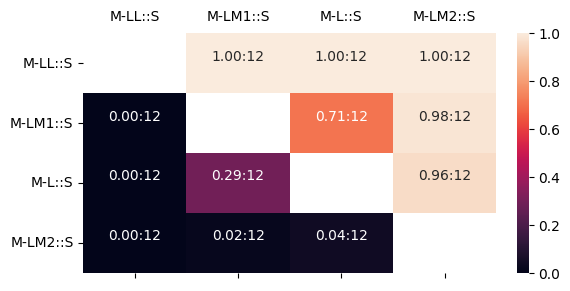

In [57]:
node_size = "S"
first_pattern = {"M"}
second_pattern = {"L", "LL", "LM1", "LM2"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [58]:
key1 = "ng"
key2 = "lateral_small"
selectivity_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    selectivity_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]

    selectivity_score[key1][key2][i_lc].append(i_entropy.mean())

selectivity_score[key1][key2]

{'M-LL::S': [4, 0.3138323331630556],
 'M-LM1::S': [3, 0.2836956365090965],
 'M-L::S': [2, 0.27990688757625465],
 'M-LM2::S': [1, 0.2656206887600389]}

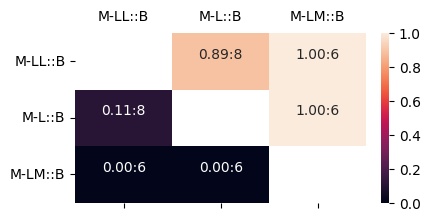

In [59]:
node_size = "B"
first_pattern = {"M"}
second_pattern = {"L", "LL", "LM"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [60]:
key1 = "ng"
key2 = "lateral_big"
selectivity_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    selectivity_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]

    selectivity_score[key1][key2][i_lc].append(i_entropy.mean())

selectivity_score[key1][key2]

{'M-LL::B': [3, 0.2192070528638506],
 'M-L::B': [2, 0.21842114860972453],
 'M-LM::B': [1, 0.17282538018886465]}

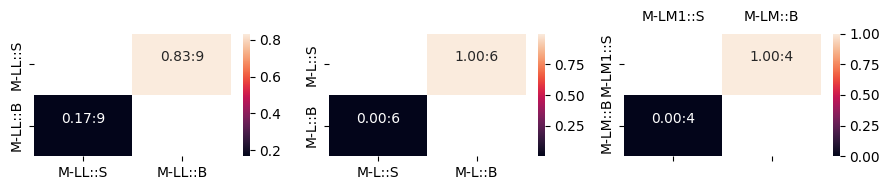

In [61]:
key1 = "ng"
key2 = "small_big"
selectivity_score[key1][key2] = {}

first_pattern = {"M"}
small_aligns = ["LL", "L", "LM1"]
big_aligns = ["LL", "L", "LM"]

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows), tight_layout=True, squeeze=False)

for i in range(3):
    ax = axes[i // ncols, i % ncols]

    small_align = small_aligns[i]
    big_align = big_aligns[i]

    selectivity_score[key1][key2][small_align + "_" + big_align] = {}

    keep_lateral_combinations = [lc for lc in lateral_combinations if (lc.split("::")[1], lc.split("::")[0].split("-")[1]) in {("S", small_align), ("B", big_align)} and lc.split("::")[0].split("-")[0] in first_pattern]

    keep_muscles = muscles

    n_keep_lateral_combinations = len(keep_lateral_combinations)

    pr, heat_map, mask = _process(
        keep_lateral_combinations=keep_lateral_combinations, threshold=1
    )

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_lateral_combinations)[ind],
        yticklabels=np.array(keep_lateral_combinations)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    plt.tick_params(labeltop=True, labelbottom=False)

    for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
        selectivity_score[key1][key2][small_align + "_" + big_align][lc] = [n_keep_lateral_combinations - i]

    for i, i_lc in enumerate(keep_lateral_combinations):
        i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
        i_ind = [v[0] for v in i_com]

        i_entropy = entropy_adj[..., i_ind]
        i_entropy = i_entropy.mean(axis=-1)
        i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
        i_entropy = i_entropy[i_amp_ind, :]

        selectivity_score[key1][key2][small_align + "_" + big_align][i_lc].append(i_entropy.mean())


In [62]:
selectivity_score[key1][key2]["LL_LL"]

{'M-LL::S': [2, 0.3138323331630556], 'M-LL::B': [1, 0.2192070528638506]}

In [63]:
selectivity_score[key1][key2]["L_L"]


{'M-L::S': [2, 0.27990688757625465], 'M-L::B': [1, 0.21842114860972453]}

In [64]:
selectivity_score[key1][key2]["LM1_LM"]


{'M-LM1::S': [2, 0.2836956365090965], 'M-LM::B': [1, 0.17282538018886465]}

### Ground

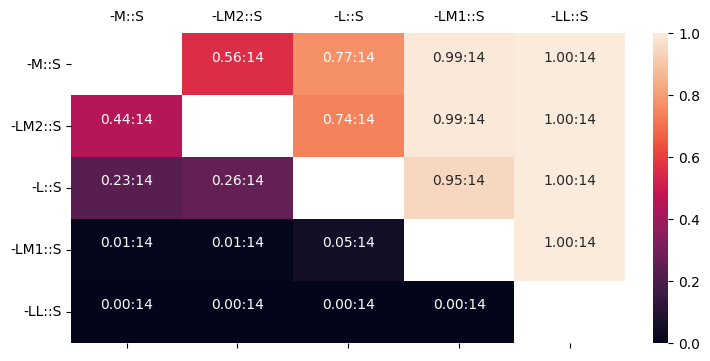

In [65]:
node_size = "S"
first_pattern = {""}
second_pattern = {"L", "LL", "LM1", "LM2", "M"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [66]:
key1 = "g"
key2 = "lateral_small"
selectivity_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    selectivity_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]

    selectivity_score[key1][key2][i_lc].append(i_entropy.mean())

selectivity_score[key1][key2]

{'-M::S': [5, 0.2892516554644829],
 '-LM2::S': [4, 0.28780321008832005],
 '-L::S': [3, 0.2822755017913929],
 '-LM1::S': [2, 0.2690407034818569],
 '-LL::S': [1, 0.23812676123667467]}

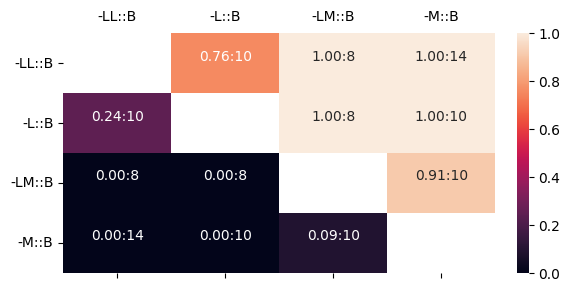

In [67]:
node_size = "B"
first_pattern = {""}
second_pattern = {"L", "LL", "LM", "M"}

keep_lateral_combinations = [lc for lc in lateral_combinations if lc.split("::")[1] == node_size and lc.split("::")[0].split("-")[0] in first_pattern and lc.split("::")[0].split("-")[1] in second_pattern]

keep_muscles = muscles

n_keep_lateral_combinations = len(keep_lateral_combinations)

pr, heat_map, mask = _process(
    keep_lateral_combinations=keep_lateral_combinations, threshold=1
)

plt.figure(figsize=(1.4 * n_keep_lateral_combinations, .7 * n_keep_lateral_combinations), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_lateral_combinations)[ind],
    yticklabels=np.array(keep_lateral_combinations)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0);

In [68]:
key1 = "g"
key2 = "lateral_big"
selectivity_score[key1][key2] = {}

for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
    selectivity_score[key1][key2][lc] = [n_keep_lateral_combinations - i]

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]

    selectivity_score[key1][key2][i_lc].append(i_entropy.mean())

selectivity_score[key1][key2]

{'-LL::B': [4, 0.22735550095535564],
 '-L::B': [3, 0.21958321036677828],
 '-LM::B': [2, 0.16780956480989914],
 '-M::B': [1, 0.18165410623996572]}

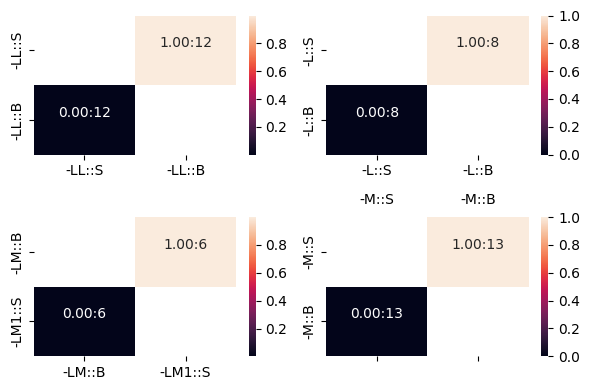

In [69]:
key1 = "g"
key2 = "small_big"
selectivity_score[key1][key2] = {}

first_pattern = {""}
small_aligns = ["LL", "L", "LM1", "M"]
big_aligns = ["LL", "L", "LM", "M"]

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows), tight_layout=True, squeeze=False)

for i in range(4):
    ax = axes[i // ncols, i % ncols]

    small_align = small_aligns[i]
    big_align = big_aligns[i]

    selectivity_score[key1][key2][small_align + "_" + big_align] = {}

    keep_lateral_combinations = [lc for lc in lateral_combinations if (lc.split("::")[1], lc.split("::")[0].split("-")[1]) in {("S", small_align), ("B", big_align)} and lc.split("::")[0].split("-")[0] in first_pattern]

    keep_muscles = muscles

    n_keep_lateral_combinations = len(keep_lateral_combinations)

    pr, heat_map, mask = _process(
        keep_lateral_combinations=keep_lateral_combinations, threshold=1
    )

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_lateral_combinations)[ind],
        yticklabels=np.array(keep_lateral_combinations)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    plt.tick_params(labeltop=True, labelbottom=False)

    for i, lc in enumerate(np.array(keep_lateral_combinations)[ind]):
        selectivity_score[key1][key2][small_align + "_" + big_align][lc] = [n_keep_lateral_combinations - i]

    for i, i_lc in enumerate(keep_lateral_combinations):
        i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
        i_ind = [v[0] for v in i_com]

        i_entropy = entropy_adj[..., i_ind]
        i_entropy = i_entropy.mean(axis=-1)
        i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
        i_entropy = i_entropy[i_amp_ind, :]

        selectivity_score[key1][key2][small_align + "_" + big_align][i_lc].append(i_entropy.mean())


In [70]:
selectivity_score[key1][key2]["LL_LL"]

{'-LL::S': [2, 0.23812676123667467], '-LL::B': [1, 0.22735550095535564]}

In [71]:
selectivity_score[key1][key2]["L_L"]


{'-L::S': [2, 0.2822755017913929], '-L::B': [1, 0.21958321036677828]}

In [72]:
selectivity_score[key1][key2]["LM1_LM"]


{'-LM::B': [2, 0.16780956480989914], '-LM1::S': [1, 0.2690407034818569]}

In [73]:
selectivity_score[key1][key2]["M_M"]

{'-M::S': [2, 0.2892516554644829], '-M::B': [1, 0.18165410623996572]}

## Selectivity vs Efficacy

In [74]:
selectivity_score.keys()

dict_keys(['g', 'ng'])

In [75]:
selectivity_score["g"].keys()

dict_keys(['lateral_small', 'lateral_big', 'small_big'])

In [76]:
axis_label_size = 12
tick_size = 12

In [77]:
key1 = "ng"
key2 = "lateral_small"

efficacy_conditions = [c for c, v in efficacy_score[key1][key2].items()]
selectivity_conditions = [c for c, v in selectivity_score[key1][key2].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_absolute_score = [(1 / efficacy_score[key1][key2][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key1][key2][c][1].item() for c in curr_conditions]

In [78]:
curr_conditions

['M-L::S', 'M-LL::S', 'M-LM1::S', 'M-LM2::S']

In [79]:
CURR = ["M - L", "M - LL", "M - LM1", "M - LM2"]

Text(0.5, 1.0, 'Small Electrodes - Degrees of Laterality')

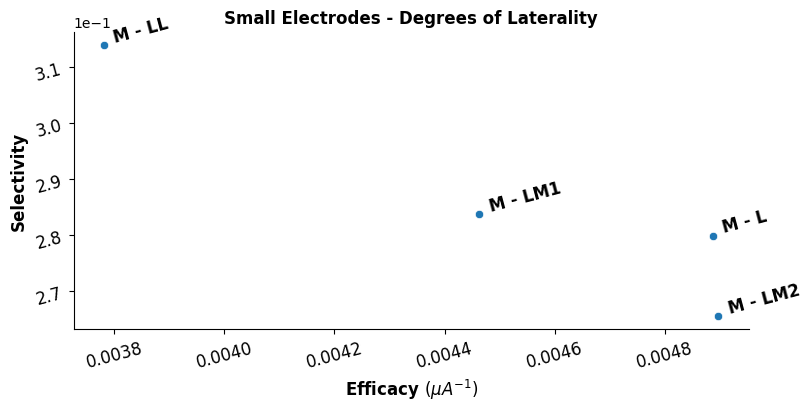

In [80]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows), constrained_layout=True, squeeze=False)

ax = axes[0, 0]

x = efficacy_absolute_score
y = selectivity_absolute_score

sns.scatterplot(x=x, y=y, ax=ax)

for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00002,
        y[i]+0.0005,
        CURR[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=15,
        wrap=True
    )
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, weight="bold")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.set_title("Small Electrodes - Degrees of Laterality", size=axis_label_size, fontweight="bold")

In [81]:
key1 = "ng"
key2 = "lateral_big"

efficacy_conditions = [c for c, v in efficacy_score[key1][key2].items()]
selectivity_conditions = [c for c, v in selectivity_score[key1][key2].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_absolute_score = [(1 / efficacy_score[key1][key2][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key1][key2][c][1].item() for c in curr_conditions]

curr_conditions

['M-L::B', 'M-LL::B', 'M-LM::B']

In [82]:
CURR = ["M - L", "M - LL", "M - LM"]

Text(0.5, 1.0, 'Big Electrodes - Degrees of Laterality')

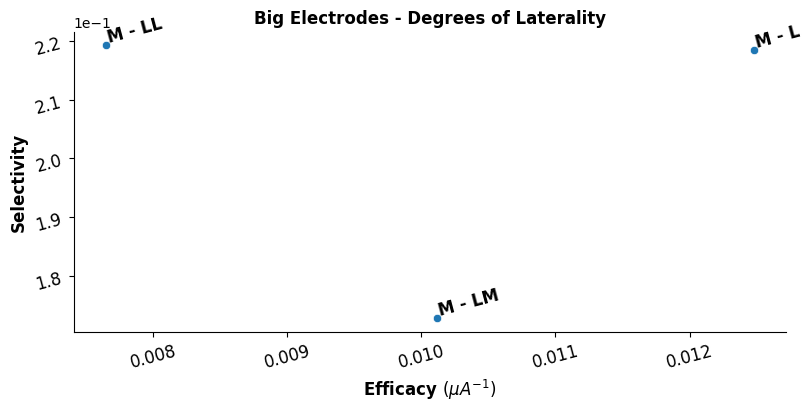

In [83]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows), constrained_layout=True, squeeze=False)

ax = axes[0, 0]

x = efficacy_absolute_score
y = selectivity_absolute_score

sns.scatterplot(x=x, y=y, ax=ax)

for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00002,
        y[i]+0.0005,
        CURR[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=15,
        wrap=True
    )
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, weight="bold")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.set_title("Big Electrodes - Degrees of Laterality", size=axis_label_size, fontweight="bold")

In [84]:
key1 = "ng"
key2 = "small_big"

efficacy_score[key1][key2].keys()


dict_keys(['LL_LL', 'L_L', 'LM1_LM'])

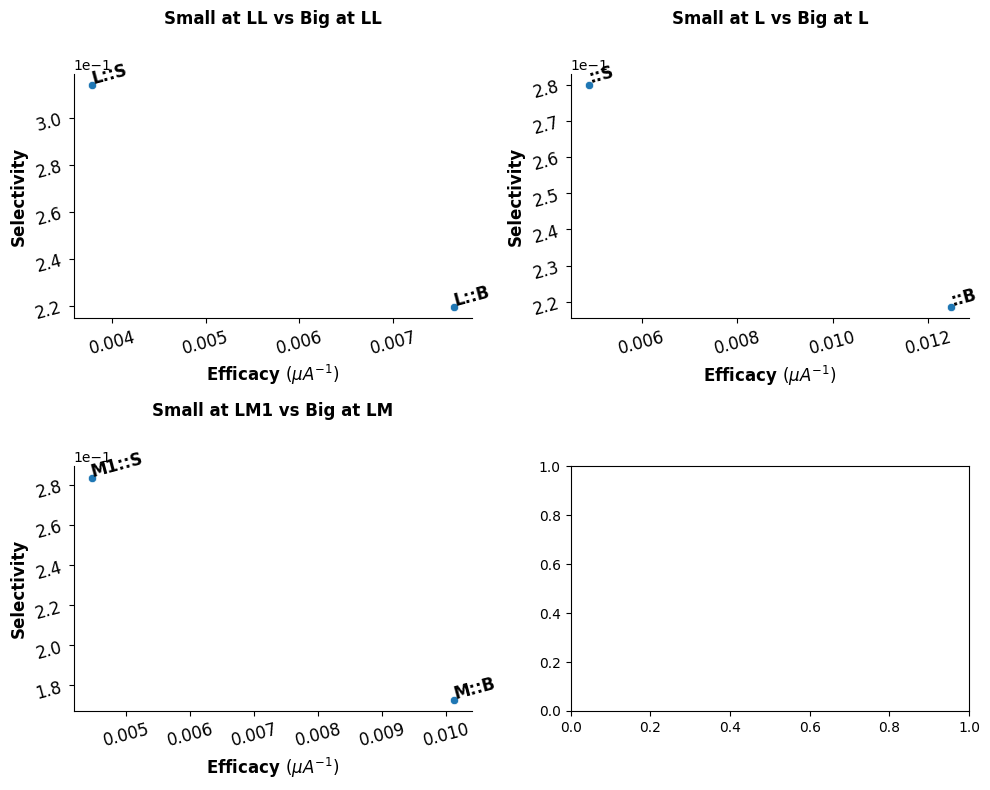

In [85]:

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), tight_layout=True, squeeze=False)

ax_ind = 0
for key3 in efficacy_score[key1][key2].keys():
    ax = axes[ax_ind // ncols, ax_ind % ncols]
    ax_ind += 1
    efficacy_conditions = [c for c, v in efficacy_score[key1][key2][key3].items()]
    selectivity_conditions = [c for c, v in selectivity_score[key1][key2][key3].items()]

    assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
    curr_conditions = sorted(efficacy_conditions)

    efficacy_absolute_score = [(1 / efficacy_score[key1][key2][key3][c][1]) for c in curr_conditions]
    selectivity_absolute_score = [selectivity_score[key1][key2][key3][c][1].item() for c in curr_conditions]

    CURR = [c[3:] for c in curr_conditions]

    x = efficacy_absolute_score
    y = selectivity_absolute_score

    sns.scatterplot(x=x, y=y, ax=ax)

    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.00002,
            y[i]+0.0005,
            CURR[i],
            horizontalalignment='left',
            size='large',
            color='black',
            weight='semibold',
            rotation=15,
            wrap=True
        )
    ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
    ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, weight="bold")
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=True,
        labelrotation=15,
        labelsize=tick_size
    )
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelrotation=15,
        labelsize=tick_size
    )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
    ax.set_title(f"Small at {key3.split('_')[0]} vs Big at {key3.split('_')[1]}\n\n", size=axis_label_size, fontweight="bold")
    


In [86]:
key1 = "g"
key2 = "lateral_small"

efficacy_conditions = [c for c, v in efficacy_score[key1][key2].items()]
selectivity_conditions = [c for c, v in selectivity_score[key1][key2].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_absolute_score = [(1 / efficacy_score[key1][key2][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key1][key2][c][1].item() for c in curr_conditions]

curr_conditions

['-L::S', '-LL::S', '-LM1::S', '-LM2::S', '-M::S']

In [87]:
CURR = ["L", "LL", "LM1", "LM2", "M"]

Text(0.5, 1.0, 'Small Electrodes - Degrees of Laterality')

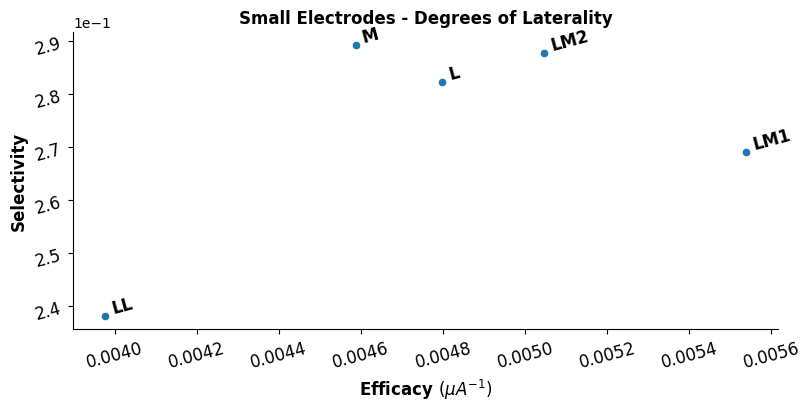

In [88]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows), constrained_layout=True, squeeze=False)

ax = axes[0, 0]

x = efficacy_absolute_score
y = selectivity_absolute_score

sns.scatterplot(x=x, y=y, ax=ax)

for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00002,
        y[i]+0.0005,
        CURR[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=15,
        wrap=True
    )
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, weight="bold")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.set_title("Small Electrodes - Degrees of Laterality", size=axis_label_size, fontweight="bold")

In [89]:
key1 = "ng"
key2 = "lateral_big"

efficacy_conditions = [c for c, v in efficacy_score[key1][key2].items()]
selectivity_conditions = [c for c, v in selectivity_score[key1][key2].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_absolute_score = [(1 / efficacy_score[key1][key2][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key1][key2][c][1].item() for c in curr_conditions]

curr_conditions

['M-L::B', 'M-LL::B', 'M-LM::B']

In [90]:
CURR = ["M - L", "M - LL", "M - LM"]

Text(0.5, 1.0, 'Big Electrodes - Degrees of Laterality')

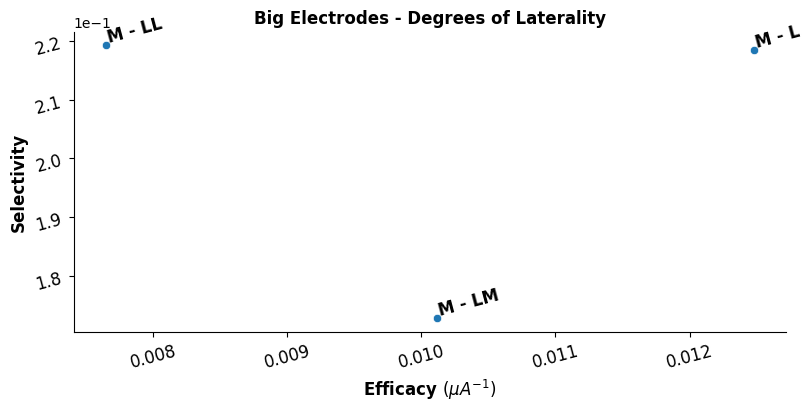

In [91]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows), constrained_layout=True, squeeze=False)

ax = axes[0, 0]

x = efficacy_absolute_score
y = selectivity_absolute_score

sns.scatterplot(x=x, y=y, ax=ax)

for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00002,
        y[i]+0.0005,
        CURR[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=15,
        wrap=True
    )
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, weight="bold")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.set_title("Big Electrodes - Degrees of Laterality", size=axis_label_size, fontweight="bold")

In [92]:
key1 = "ng"
key2 = "small_big"

efficacy_score[key1][key2].keys()


dict_keys(['LL_LL', 'L_L', 'LM1_LM'])

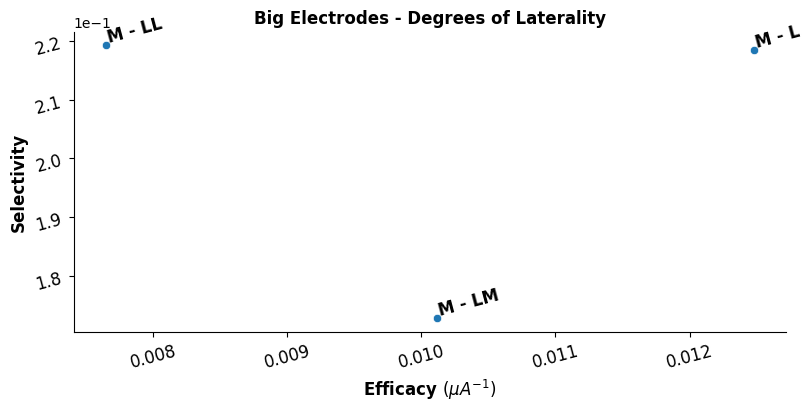

In [93]:
fig

In [117]:
efficacy_score[key1][key2].keys()

dict_keys(['LL_LL', 'L_L', 'LM1_LM'])

AssertionError: 

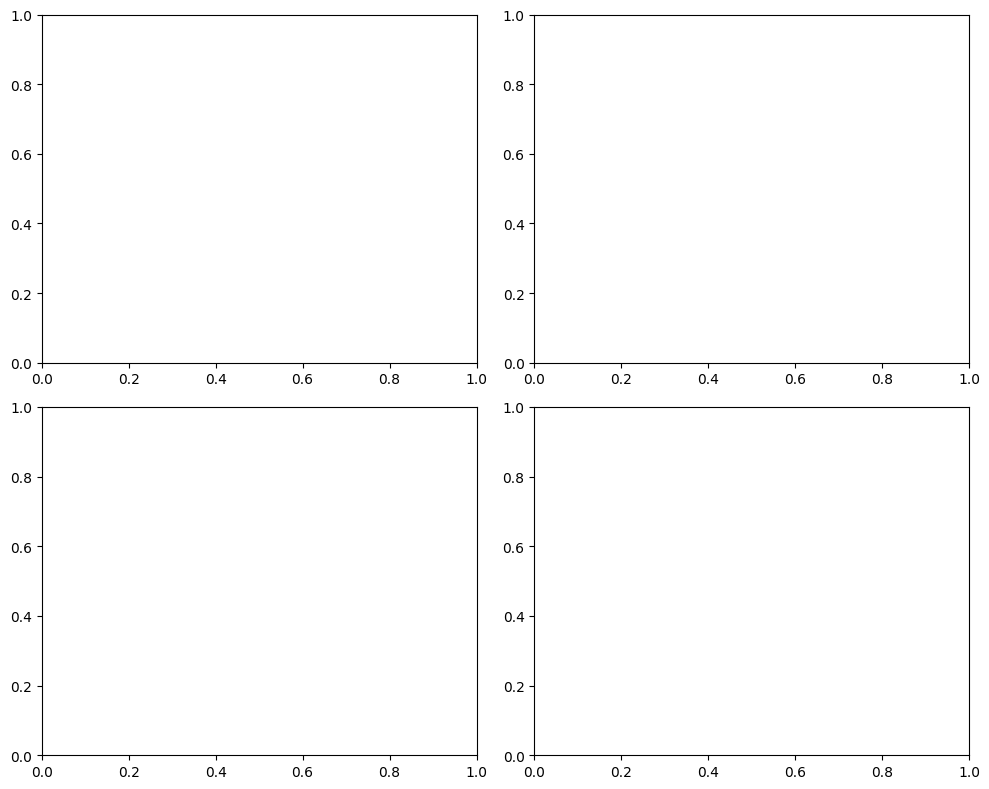

In [116]:

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), tight_layout=True, squeeze=False)

ax_ind = 0
for key3 in efficacy_score[key1][key2].keys():
    ax = axes[ax_ind // ncols, ax_ind % ncols]
    ax_ind += 1
    efficacy_conditions = [c for c, v in efficacy_score[key1][key2][key3].items()]
    selectivity_conditions = [c for c, v in selectivity_score[key1][key2][key3].items()]

    assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
    curr_conditions = sorted(efficacy_conditions)

    efficacy_absolute_score = [(1 / efficacy_score[key1][key2][key3][c][1]) for c in curr_conditions]
    selectivity_absolute_score = [selectivity_score[key1][key2][key3][c][1].item() for c in curr_conditions]

    CURR = [c[3:] for c in curr_conditions]

    x = efficacy_absolute_score
    y = selectivity_absolute_score

    sns.scatterplot(x=x, y=y, ax=ax)

    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.00002,
            y[i]+0.0005,
            CURR[i],
            horizontalalignment='left',
            size='large',
            color='black',
            weight='semibold',
            rotation=15,
            wrap=True
        )
    ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
    ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, weight="bold")
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=True,
        labelrotation=15,
        labelsize=tick_size
    )
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelrotation=15,
        labelsize=tick_size
    )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
    ax.set_title(f"Small at {key3.split('_')[0]} vs Big at {key3.split('_')[1]}\n\n", size=axis_label_size, fontweight="bold")
    


In [95]:
curr_conditions

['M-LM1::S', 'M-LM::B']

In [100]:
key1

'ng'

In [101]:
key2

'small_big'

AssertionError: 

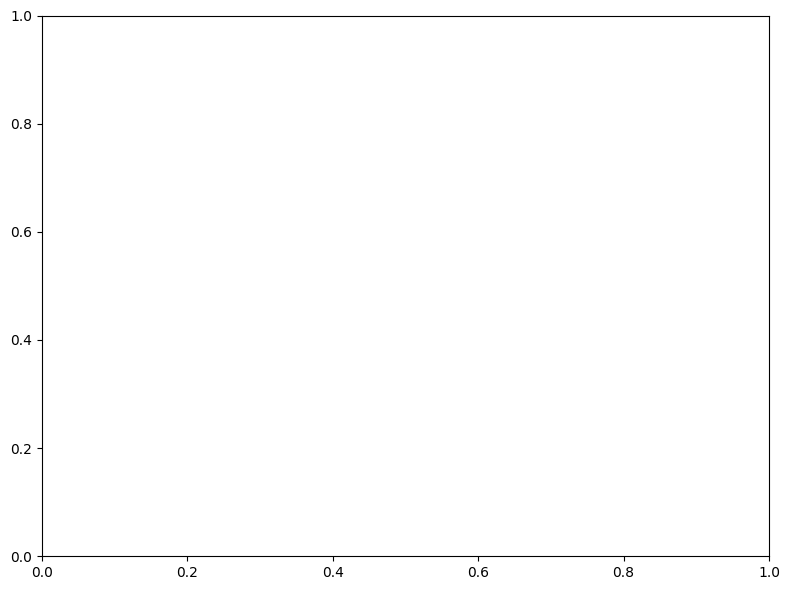

In [115]:
tick_size = 16
axis_label_size = 16

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6), tight_layout=True, squeeze=False)

ax = axes[0, 0]

for key3 in efficacy_score[key1][key2].keys():
    efficacy_conditions = [c for c, v in efficacy_score[key1][key2][key3].items()]
    selectivity_conditions = [c for c, v in selectivity_score[key1][key2][key3].items()]

    assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
    curr_conditions = sorted(efficacy_conditions)

    efficacy_absolute_score = [(1 / efficacy_score[key1][key2][key3][c][1]) for c in curr_conditions]
    selectivity_absolute_score = [selectivity_score[key1][key2][key3][c][1].item() for c in curr_conditions]

    CURR = [c[2:] for c in curr_conditions]

    x = efficacy_absolute_score
    y = selectivity_absolute_score

    print(x, y)

    sns.scatterplot(x=x, y=y, ax=ax, color='b')

    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.00002,
            y[i]+0.0005,
            CURR[i],
            horizontalalignment='left',
            size='large',
            color='black',
            weight='semibold',
            rotation=15,
            wrap=True
        )

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, fontweight="bold")
ax.set_ylabel("Selectivity $(A.U.)$", size=axis_label_size, fontweight="bold")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

# ax.set_xlim(left=0.46/100)
# ax.set_ylim(bottom=2.15/10, top=2.85/10)
# ax.set_yticks(np.array([2.1, 2.3, 2.5]) / 10)
# ax.set_xticks(np.array([0.5, 0.8, 1.1]) / 100)
fig.savefig("/home/vishu/paper/figs/plane-shield-2.svg", dpi=300)


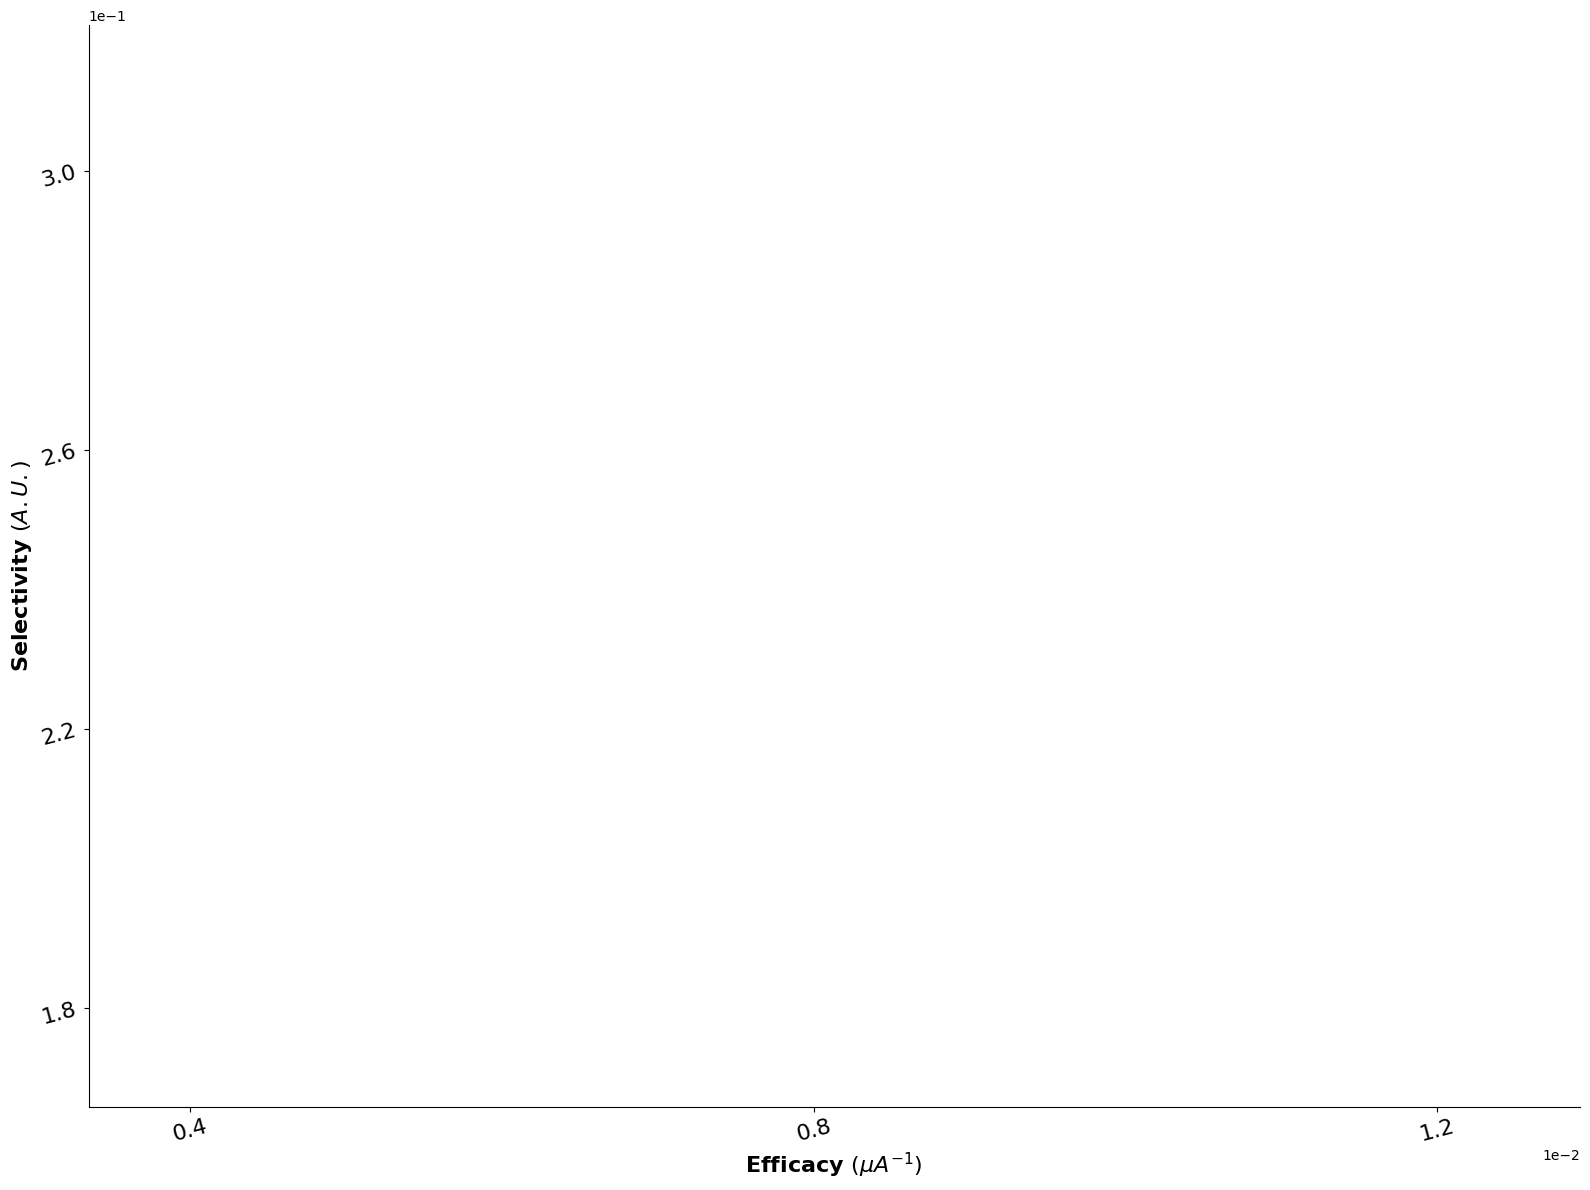

In [97]:
tick_size = 16
axis_label_size = 16

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12), tight_layout=True, squeeze=False)

ax = axes[0, 0]

for key3 in efficacy_score[key1][key2].keys():
    efficacy_conditions = [c for c, v in efficacy_score[key1][key2][key3].items()]
    selectivity_conditions = [c for c, v in selectivity_score[key1][key2][key3].items()]

    assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
    curr_conditions = sorted(efficacy_conditions)

    efficacy_absolute_score = [(1 / efficacy_score[key1][key2][key3][c][1]) for c in curr_conditions]
    selectivity_absolute_score = [selectivity_score[key1][key2][key3][c][1].item() for c in curr_conditions]

    CURR = [c[2:] for c in curr_conditions]

    x = efficacy_absolute_score
    y = selectivity_absolute_score

    sns.scatterplot(x=x, y=y, ax=ax, color='white')

    # for i in range(len(curr_conditions)):
    #     ax.text(
    #         x[i]+0.00002,
    #         y[i]+0.0005,
    #         CURR[i],
    #         horizontalalignment='left',
    #         size='large',
    #         color='black',
    #         weight='semibold',
    #         rotation=15,
    #         wrap=True
    #     )

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, fontweight="bold")
ax.set_ylabel("Selectivity $(A.U.)$", size=axis_label_size, fontweight="bold")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

# ax.set_xlim(left=0.46/100)
# ax.set_ylim(bottom=2.15/10, top=2.85/10)
ax.set_yticks(np.array([1.8, 2.2, 2.6, 3]) / 10)
ax.set_xticks(np.array([0.4, 0.8, 1.2]) / 100)
fig.savefig("/home/vishu/paper/figs/plane-c.svg", dpi=300)

In [102]:
keep_lateral_combinations

['-M::B', '-M::S']

In [104]:
keep_lateral_combinations

['M-LL::B', 'M-LL::S']

In [113]:
keep_lateral_combinations = [lc for lc in lateral_combinations if (lc.split("::")[1], lc.split("::")[0].split("-")[1]) in {("S", "LL"), ("B", "LL"), ("S", "L"), ("B", "L"), ("S", "LM1"), ("B", "LM")} and lc.split("::")[0].split("-")[0] in first_pattern]

In [126]:
size_efficacy = None

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    i_a = i_a.mean(axis=-1)

    if size_efficacy is None:
        size_efficacy = i_a.reshape(-1, 1)
    else:
        size_efficacy = np.concatenate([size_efficacy, i_a.reshape(-1, 1)], axis=-1)

size_efficacy.shape

(9000, 6)

In [114]:
size_selectivity = None

for i, i_lc in enumerate(keep_lateral_combinations):
    i_com = [(i, c) for i, c in enumerate(combinations_inv_) if c[-1] == i_lc]
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]

    if size_selectivity is None:
        size_selectivity = i_entropy.reshape(-1, 1)
    else:
        size_selectivity = np.concatenate([size_selectivity, i_entropy.reshape(-1, 1)], axis=-1)

size_selectivity.shape


(9000, 6)

In [120]:
keep_lateral_combinations

['M-L::B', 'M-L::S', 'M-LL::B', 'M-LL::S', 'M-LM1::S', 'M-LM::B']

In [119]:
size_selectivity.mean(axis=0)

array([0.21842115, 0.27990689, 0.21920705, 0.31383233, 0.28369564,
       0.17282538])

In [128]:
dst_dir = '/home/vishu/paper/data/size/'

save_mat = np.array(keep_lateral_combinations)
fname = 'keep_lateral_combinations.npy'

dst = os.path.join(dst_dir, fname)

np.save(dst, save_mat)

save_mat

array(['M-L::B', 'M-L::S', 'M-LL::B', 'M-LL::S', 'M-LM1::S', 'M-LM::B'],
      dtype='<U8')

In [130]:
dst_dir = '/home/vishu/paper/data/size/'

save_mat = size_efficacy
fname = 'size_efficacy.npy'

dst = os.path.join(dst_dir, fname)

np.save(dst, save_mat)

save_mat.mean(axis=0)

array([ 80.13547806, 204.61696744, 130.7271419 , 264.37482651,
       224.07529342,  98.77599084])

In [131]:
dst_dir = '/home/vishu/paper/data/size/'

save_mat = size_selectivity
fname = 'size_selectivity.npy'

dst = os.path.join(dst_dir, fname)

np.save(dst, save_mat)

save_mat.mean(axis=0)

array([0.21842115, 0.27990689, 0.21920705, 0.31383233, 0.28369564,
       0.17282538])